# <center>ДЗ-1 (Временные ряды)</center>

# Работа с временными рядами.
Задание: Известно ежемесячное число смертей в результате несчастного случая в США с января 1973 по декабрь 1978, необходимо построить прогноз на следующие 2 года. Ожидаю в конце уидеть график.
При выполнении работ напишите введение и вывод. Посторайтесь коментировать то что делаете. 

In [5]:
import pandas as pd

Загружаем и смотрим датасет

In [138]:
dataset = pd.read_csv('accidental-deaths-in-usa-monthly.csv', index_col=['Month'], parse_dates=['Month'])
#index_col=['Time'], parse_dates=['Time']
dataset.head(20)

,"Accidental deaths in USA: monthly, 1973 ? 1978"
Month,
1973-01-01,9007
1973-02-01,8106
1973-03-01,8928
1973-04-01,9137
1973-05-01,10017
1973-06-01,10826
1973-07-01,11317
1973-08-01,10744
1973-09-01,9713


In [23]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 1973-01-01 to 1978-12-01
Data columns (total 1 columns):
 #   Column                                          Non-Null Count  Dtype
---  ------                                          --------------  -----
 0   Accidental deaths in USA: monthly, 1973 ? 1978  72 non-null     int64
dtypes: int64(1)
memory usage: 1.1 KB


Импортируем нужные библиотеки и задаем функцию для отрисовки графиков

In [81]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
#from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

Визуализируем датасет

In [13]:
plotly_df(dataset)

Зададим функцию отрисовки графика скользящей средней

In [62]:
def plotMovingAverage(series, n):
    
    """
    series - dataframe with timeseries
    n - rolling window size 
    
    """
    
    rolling_mean = series.rolling(window=n).mean()
    
    # При желании, можно строить и доверительные интервалы для сглаженных значений
    # rolling_std =  series.rolling(window=n).std()
    # upper_bond = rolling_mean+1.96*rolling_std
    # lower_bond = rolling_mean-1.96*rolling_std
    
    plt.figure(figsize=(30,10))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

Сгладим датасет с помощью скользящей средней

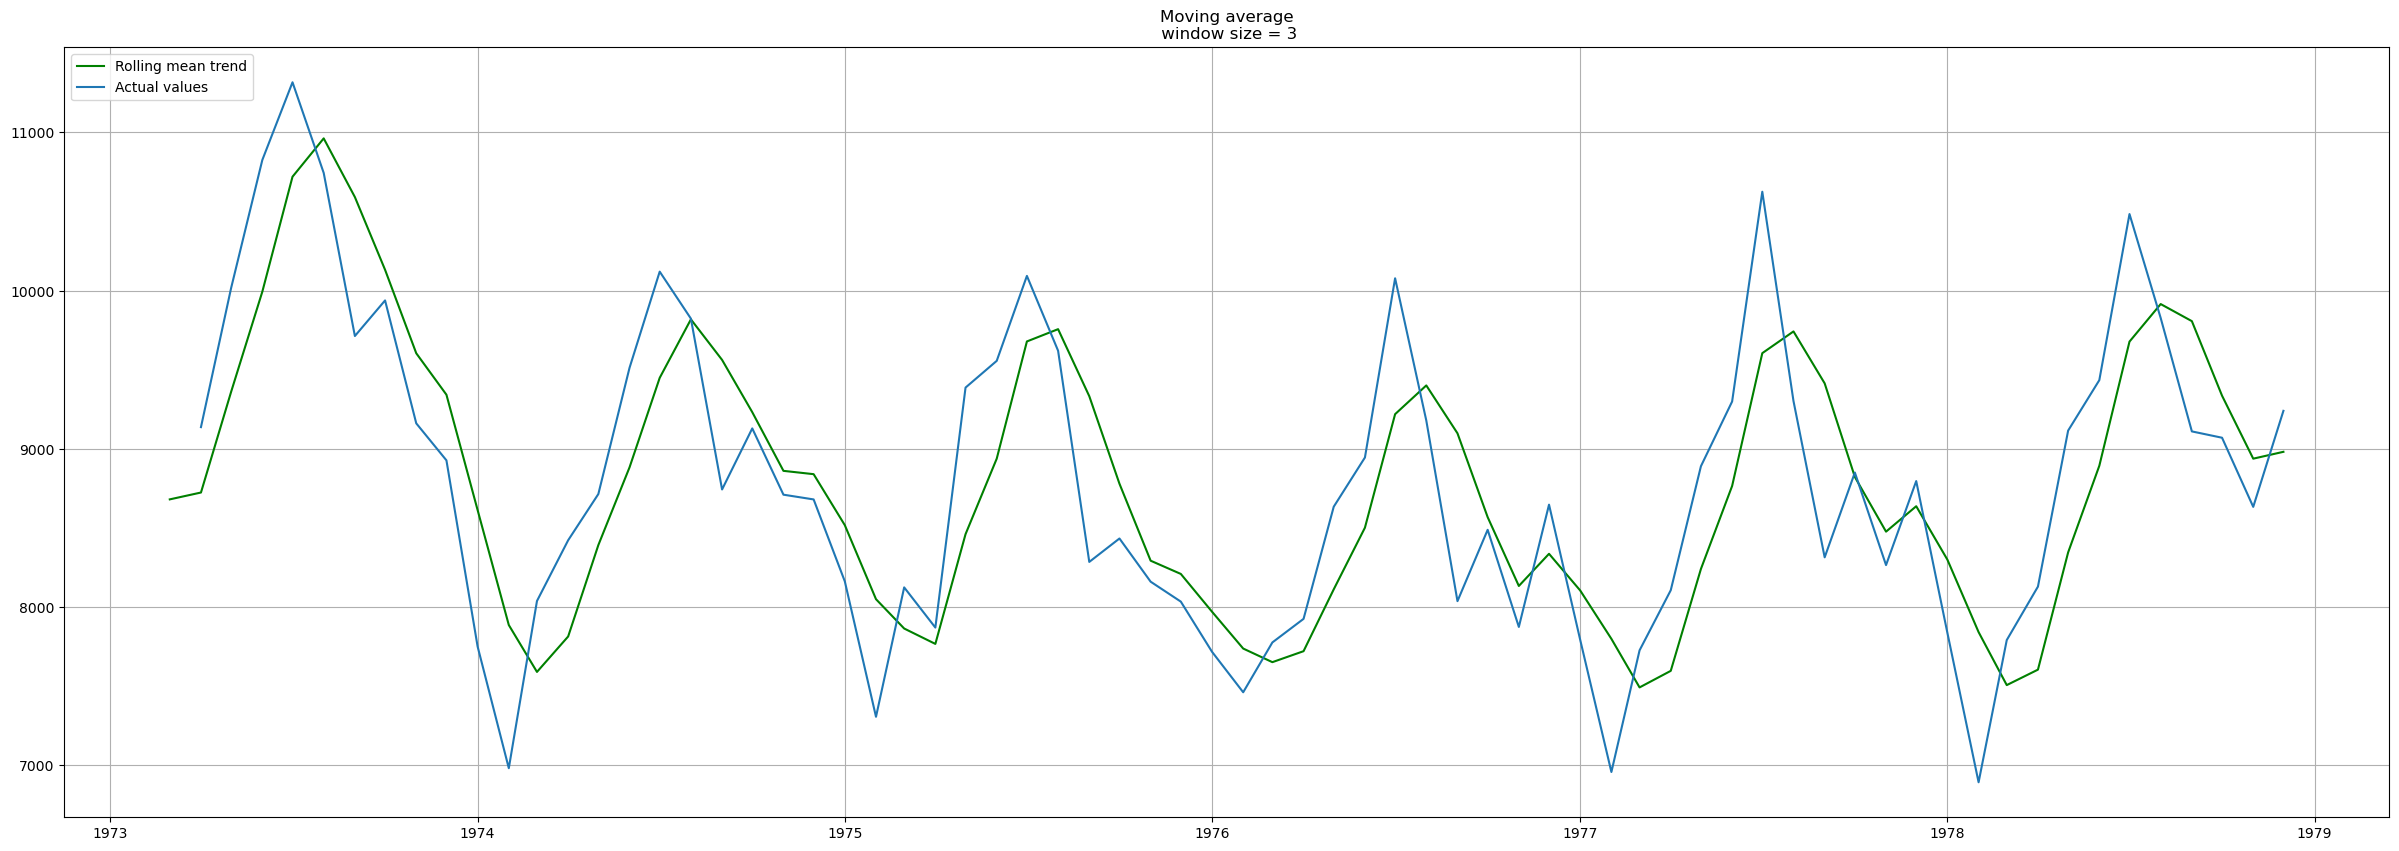

In [152]:
plotMovingAverage(dataset, 3) # сглаживаем по годам

Вывод: Наблюдается годовая сезонность смертей

Делаем предсказание с помощью тройного экспоненциального сглаживания a.k.a. Holt-Winters

Инициализация класса Holt-Winters

In [339]:
class HoltWinters:
    
    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf
    
    
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                
                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                
            
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])


            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
                
                
                
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])
            
            
        

Задание функции кросс-валидации на временном ряду

In [340]:
from sklearn.model_selection import TimeSeriesSplit
counter = 0
def timeseriesCVscore(x):
    global counter
    counter+=1

    # вектор ошибок
    errors = []
    
    values = data.values
    alpha, beta, gamma = x
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train], slen = 6, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

Не знаю почему, но по идее параметр slen должен быть 12, но если он 12, то выдает ошибку при применении функции minimize

In [341]:
# Смотрю на то как разбается датасет при кроссвалидации
tscv = TimeSeriesSplit(n_splits=3) 
list(tscv.split(data.values))

[(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
  array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23]),
  array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35]),
  array([36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]))]

Подбор оптимальных параметров

In [342]:
%%time
data = dataset['Accidental deaths in USA: monthly, 1973 ? 1978'][:-24] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
#TNC - Минимизируйте скалярную функцию одной или нескольких переменных, используя усеченный алгоритм Ньютона (TNC). 
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

1.0 0.01405900369583496 0.10147945617279042
Wall time: 240 ms


Передаем оптимальные значения модели

In [343]:
data1 = dataset['Accidental deaths in USA: monthly, 1973 ? 1978']
model = HoltWinters(data1[:-24], slen = 12, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 24, scaling_factor = 2.56)
model.triple_exponential_smoothing()

Среднее квадратичное отклонение

In [344]:
print(mean_squared_error(data1.values[-24:],model.result[-24:])**0.5)

596.6214450551213


Функция отрисовки графика тройного экспоненциального сглаживания

In [345]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data1))
    Anomalies[data1.values<model.LowerBond] = data1.values[data1.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data1.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data1)-24, len(data1), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

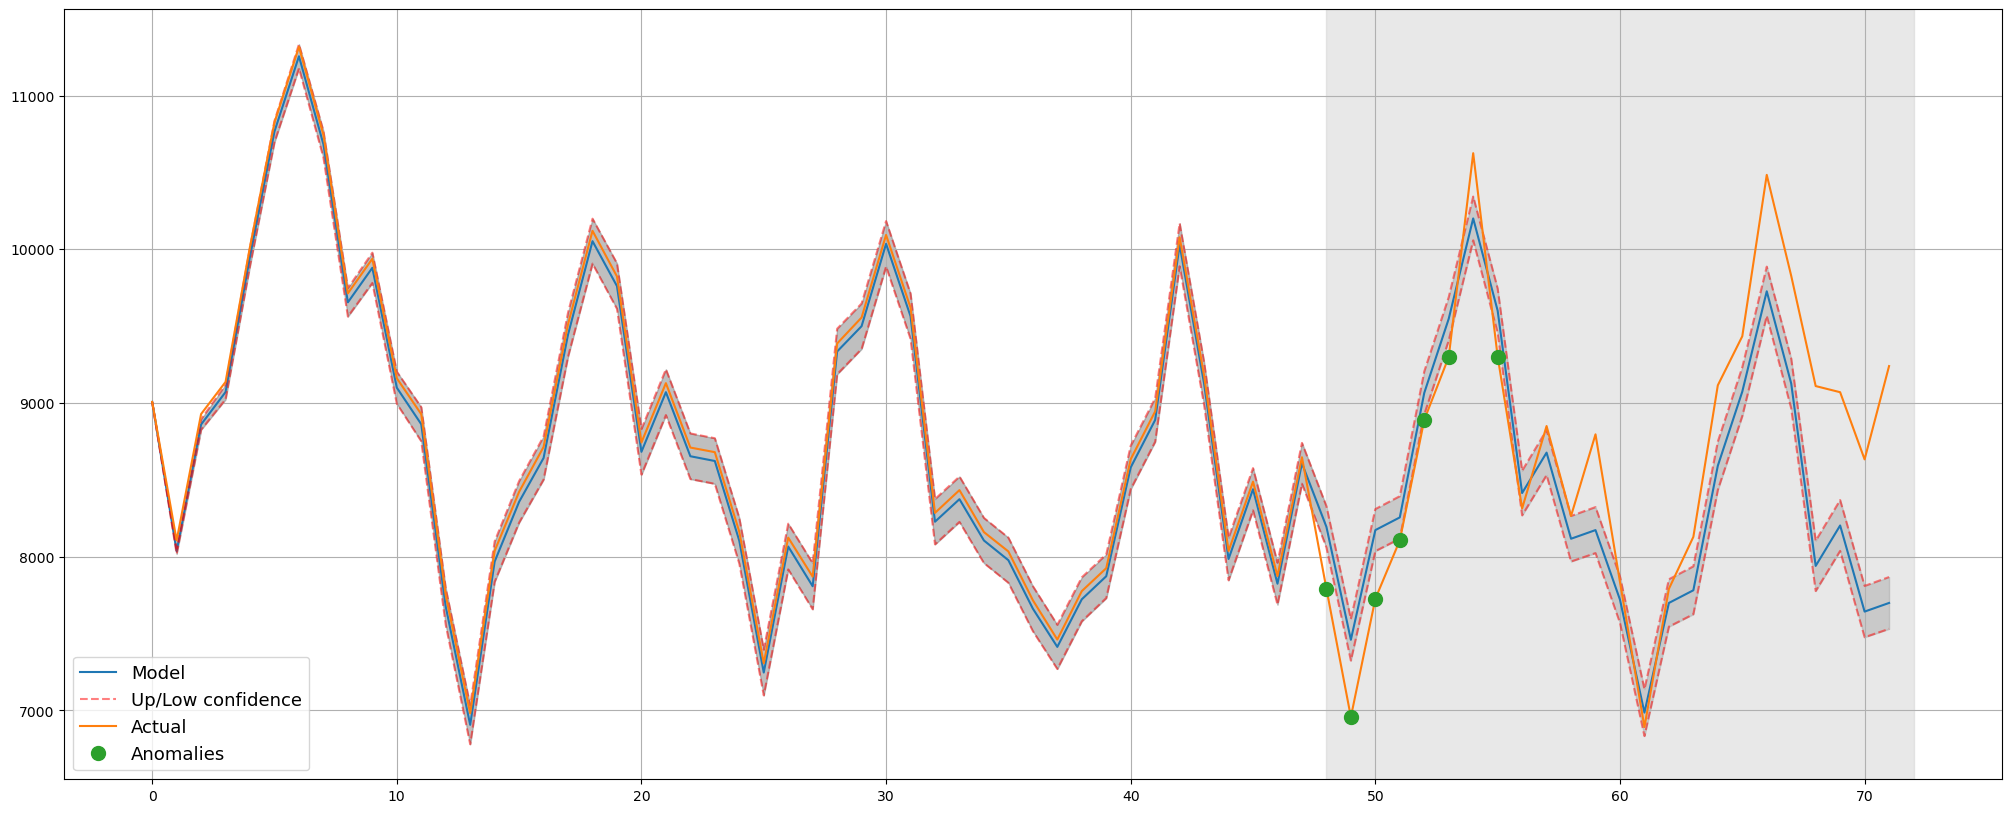

In [346]:
plotHoltWinters()

Вывод: Видно что на первый год предсказания точнее, чем на второй год

Cмоделированное отклонение

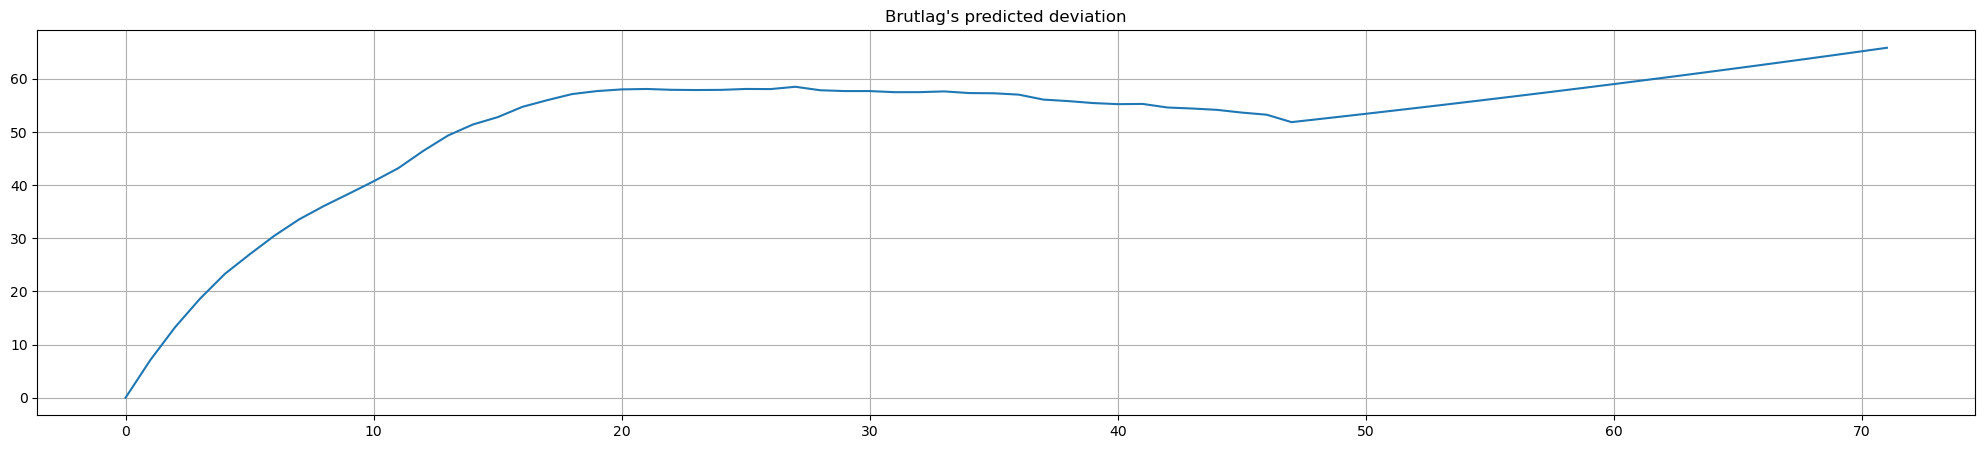

In [347]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

## Избавляемся от нестационарности и строим SARIMA

Код для отрисовки графиков

In [348]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        #Расширенный тест единичного корня Дики-Фуллера.
        #Расширенный тест Дики-Фуллера можно использовать для проверки единичного корня в одномерном процессе при наличии последовательной корреляции.


        plt.tight_layout()
    return 

D:\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



Критерий Дики-Фуллера: p=0.102481


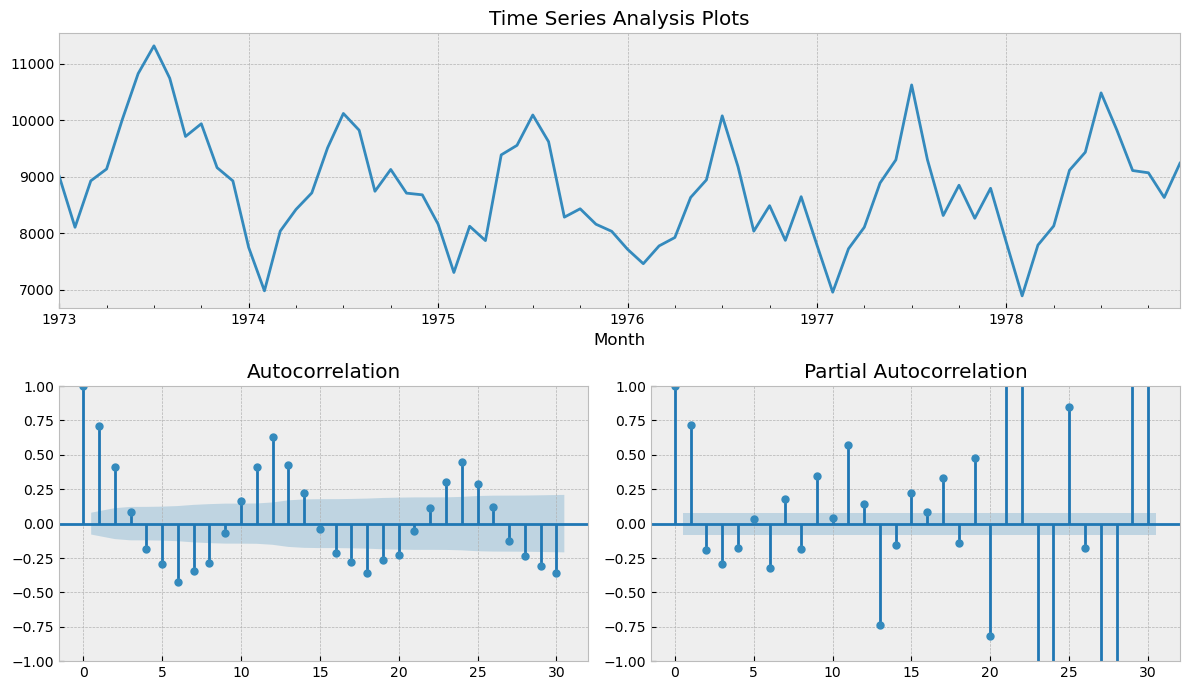

In [349]:
tsplot(dataset['Accidental deaths in USA: monthly, 1973 ? 1978'], lags=30)

Исходный ряд стационарным не является, критерий Дики-Фуллера не отверг нулевую гипотезу о наличии единичного корня. Попробуем стабилизировать дисперсию преоразованием Бокса-Кокса

D:\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



Критерий Дики-Фуллера: p=0.086943
Оптимальный параметр преобразования Бокса-Кокса: -0.275235


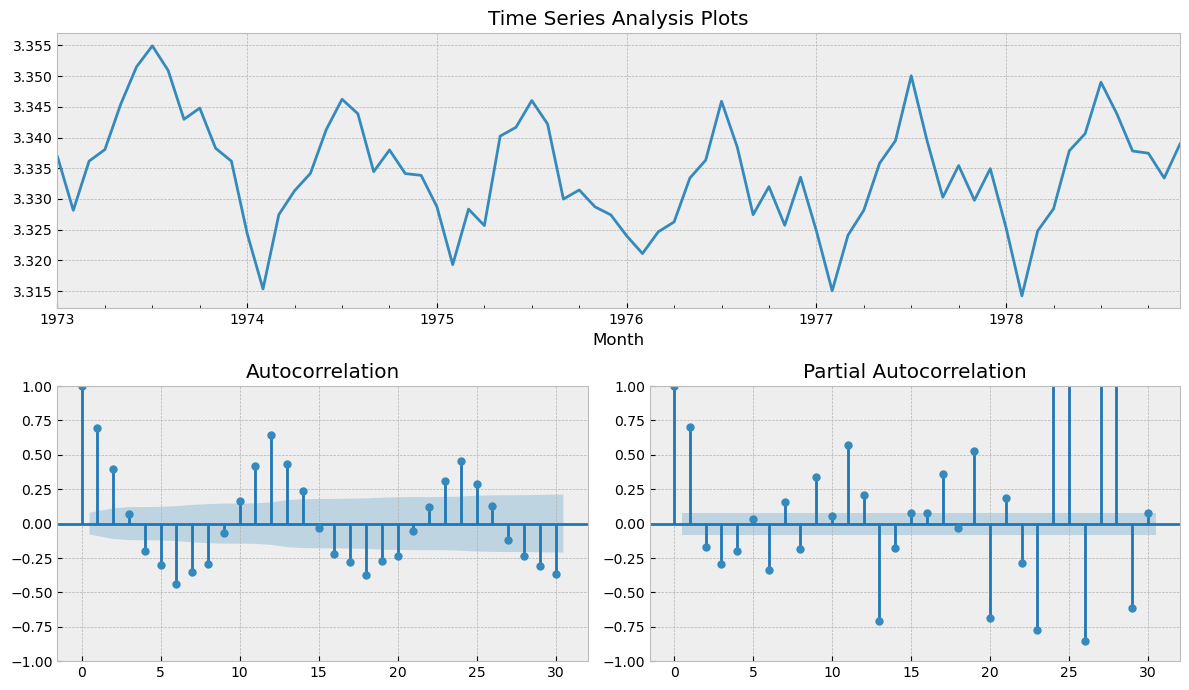

In [350]:
def invboxcox(y,lmbda):
    # обратное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))


data = dataset.copy()
data['Accidental deaths box'], lmbda = scs.boxcox(data['Accidental deaths in USA: monthly, 1973 ? 1978'])
tsplot(data['Accidental deaths box'], lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера по-прежнему не отвергает гипотезу о нестационарности ряда. А автокорреляционная функция явно намекает на сезонность в получившемся ряде. Возьмём сезонные разности:

D:\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



Критерий Дики-Фуллера: p=0.005633


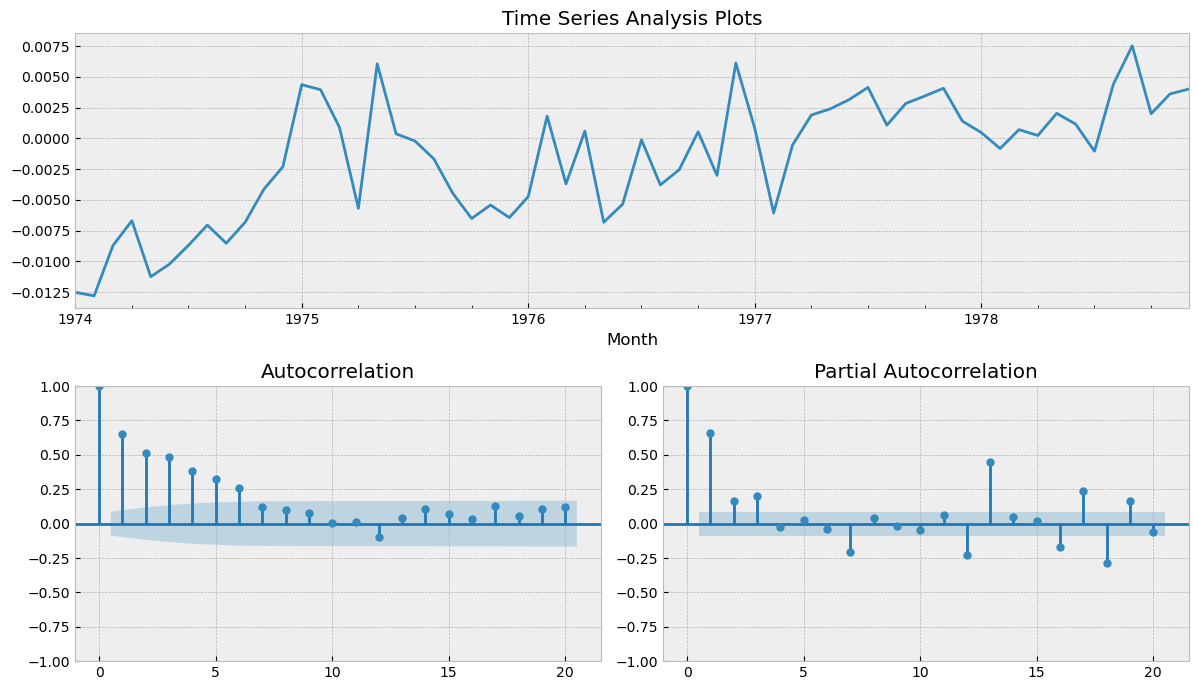

In [351]:
data['Accidental deaths box_season'] = data['Accidental deaths box'] - data['Accidental deaths box'].shift(12)
tsplot(data['Accidental deaths box_season'][12:], lags=20)

Критерий Дики-Фуллера теперь отвергает нулевую гипотезу о нестационарности (p-value меньше уровня значимости  0.05), но автокорреляционная функция всё ещё выглядит нехорошо из-за большого числа значимых лагов. Так как на графике частной автокорреляционной функции значим лишь один лаг, стоит взять еще первые разности, чтобы привести, наконец, ряд к стационарному виду.

D:\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



Критерий Дики-Фуллера: p=0.000000


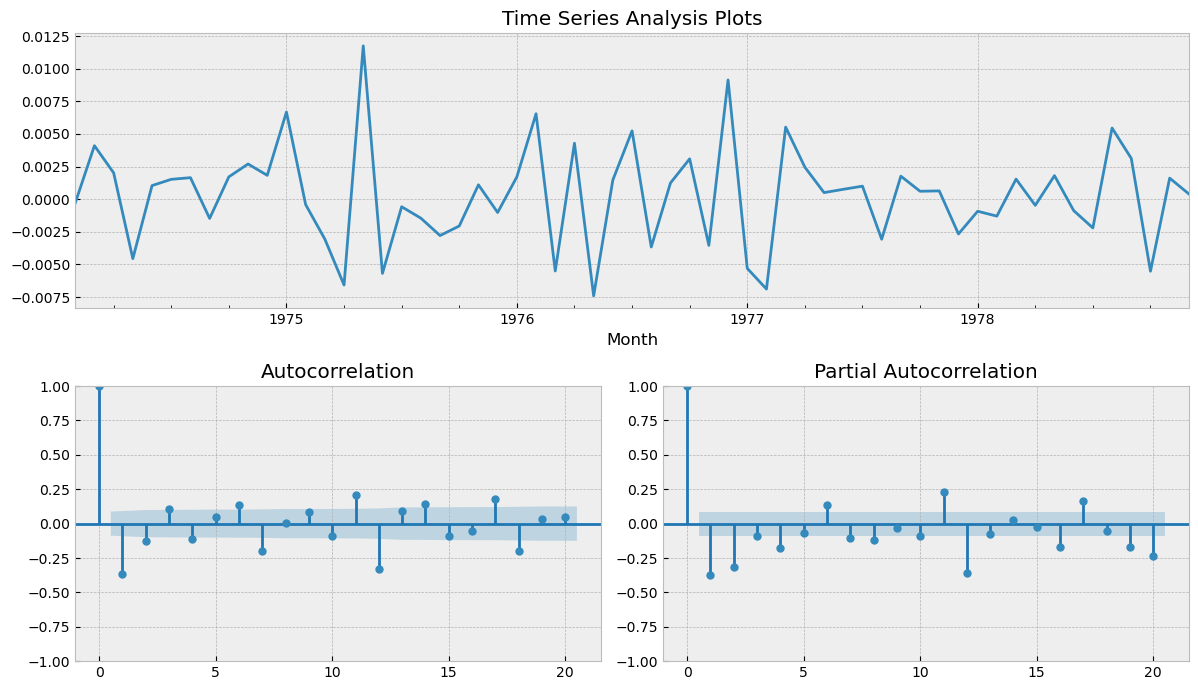

In [353]:
data['Users_box_season_diff'] = data['Accidental deaths box_season'] - data['Accidental deaths box_season'].shift(1)
tsplot(data['Users_box_season_diff'][12+1:], lags=20)

Получили стационарный ряд, по автокорреляционной и частной автокорреляционной функции прикинем параметры для SARIMA модели, на забыв, что предварительно уже сделали первые и сезонные разности.

После изучения коррелограммы PACF можно сделать вывод, что p = 1, т.к. на ней только 1 лаг сильно отличнен от нуля. По коррелограмме ACF можно увидеть, что q = 1, т.к. после лага 1 значении функций резко падают.

Начальные приближения Q = 1, P = 4, q = 1, p = 1

In [357]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 2)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

40

In [358]:
parameters_list

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 3, 0),
 (0, 0, 3, 1),
 (0, 0, 4, 0),
 (0, 0, 4, 1),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 1, 2, 0),
 (0, 1, 2, 1),
 (0, 1, 3, 0),
 (0, 1, 3, 1),
 (0, 1, 4, 0),
 (0, 1, 4, 1),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 1, 0),
 (1, 0, 1, 1),
 (1, 0, 2, 0),
 (1, 0, 2, 1),
 (1, 0, 3, 0),
 (1, 0, 3, 1),
 (1, 0, 4, 0),
 (1, 0, 4, 1),
 (1, 1, 0, 0),
 (1, 1, 0, 1),
 (1, 1, 1, 0),
 (1, 1, 1, 1),
 (1, 1, 2, 0),
 (1, 1, 2, 1),
 (1, 1, 3, 0),
 (1, 1, 3, 1),
 (1, 1, 4, 0),
 (1, 1, 4, 1)]

Подбор параметров перебором

In [359]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data['Accidental deaths box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
# print(result_table.sort_values(by = 'aic', ascending=True).head())

Wall time: 25.7 s


In [360]:
best_param

(0, 1, 0, 1)

Лучшие параметры загоняем в модель:

In [361]:
%%time
best_model=sm.tsa.statespace.SARIMAX(data['Accidental deaths box'], order=(best_param[0], d, best_param[1]), 
                                        seasonal_order=(best_param[2], D, best_param[3], 12), freq='MS').fit(disp=-1)

Wall time: 97.7 ms


D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [362]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:              Accidental deaths box   No. Observations:                   72
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 256.071
Date:                            Sun, 18 Jun 2023   AIC                           -506.141
Time:                                    21:15:43   BIC                           -499.909
Sample:                                01-01-1973   HQIC                          -503.708
                                     - 12-01-1978                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5023      0.123     -4.098      0.000      -0.743      -0.262
ma.S.L12      -0.6419      0.207   

Проверим остатки модели:

D:\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



Критерий Дики-Фуллера: p=0.000643


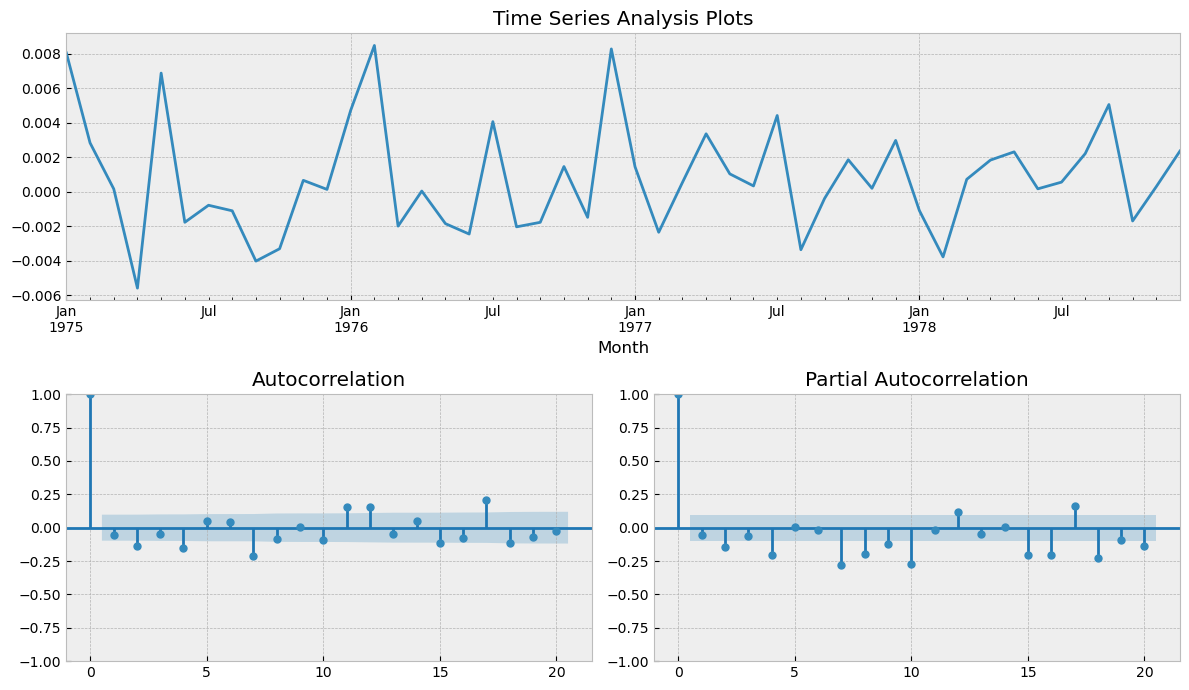

In [363]:
tsplot(best_model.resid[24:], lags=20)

Остатки стационарны, явных автокорреляций нет, построим прогноз по получившейся модели

D:\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning:

invalid value encountered in log

C:\Users\User\AppData\Local\Temp\ipykernel_13704\3488652970.py:3: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



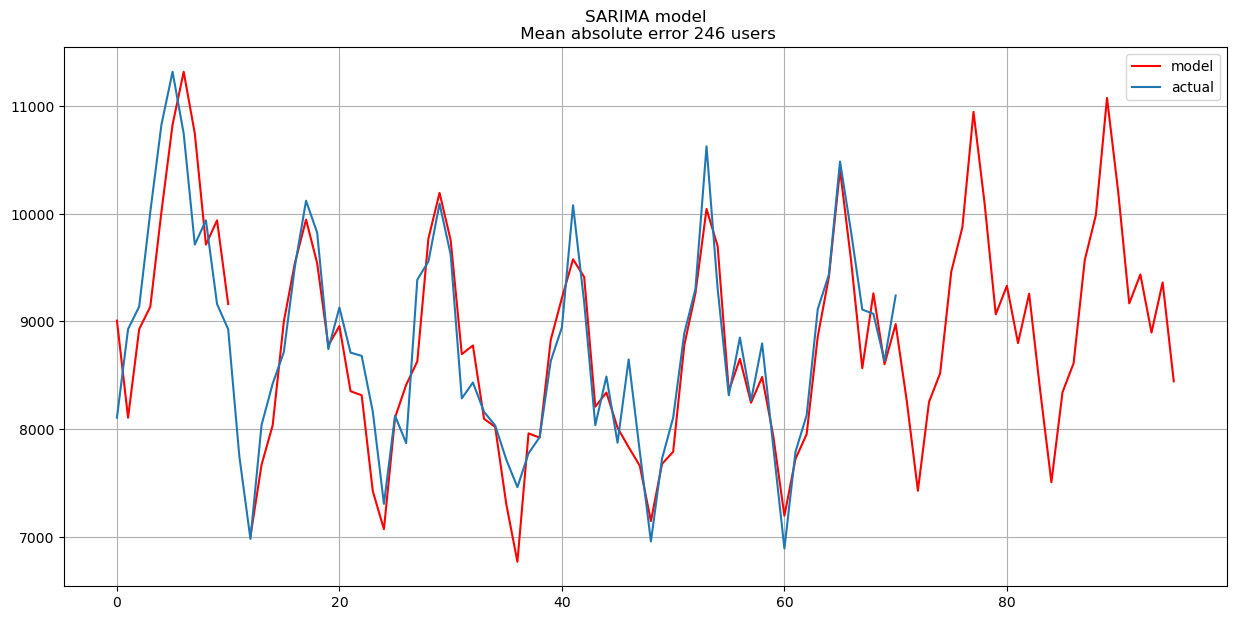

In [366]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+24), lmbda)
forecast = data.arima_model.append(forecast).values[-96:]
actual = data['Accidental deaths in USA: monthly, 1973 ? 1978'].values[-71:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} users".format(round(mean_absolute_error(data.dropna()['Accidental deaths in USA: monthly, 1973 ? 1978'], data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
# plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

В финале получаем достаточно адекватный прогноз, в среднем модель ошибалась на 246 случаев, что неплохо.

Попробуем воспользоваться библиотекой Prophet

In [368]:
%pip install Prophet

     --------------------------------------- 12.9/12.9 MB 10.7 MB/s eta 0:00:00
     ---------------------------------------- 83.2/83.2 kB 4.6 MB/s eta 0:00:00
     ---------------------------------------- 47.9/47.9 kB 2.4 MB/s eta 0:00:00
     -------------------------------------- 541.3/541.3 kB 8.4 MB/s eta 0:00:00
     ---------------------------------------- 5.8/5.8 MB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 1.4/1.4 MB 10.1 MB/s eta 0:00:00
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732001 sha256=54d761e3914cbcfc0390d7d1ec1d1eb0a626a8ced8c3b0adbe5aed8b70fecb82
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\04\1f\e5\8dd0c661cd8d252817655dc14a84f7ae045d6616594145aa81
Successfully built pymeeus
Note: you may need to restart the kernel to use updated packages.


sys:1: ResourceWarning:

unclosed socket <zmq.Socket(zmq.PUSH) at 0x28172bd16a0>

D:\anaconda3\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning:

unclosed file <_io.BufferedWriter name=5>

D:\anaconda3\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning:

unclosed file <_io.BufferedReader name=6>

D:\anaconda3\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning:

unclosed file <_io.BufferedReader name=7>



In [369]:
from prophet import Prophet

In [423]:
df = pd.read_csv('accidental-deaths-in-usa-monthly.csv')

In [424]:
df.columns = ['ds', 'y']

In [428]:
test_df = df[:-24]

In [430]:
m = Prophet()
m.fit(test_df);

21:54:48 - cmdstanpy - INFO - Chain [1] start processing
21:54:48 - cmdstanpy - INFO - Chain [1] done processing


In [431]:
future = m.make_future_dataframe(periods=24, freq = 'M')
future.tail()

,ds
67,1978-07-31
68,1978-08-31
69,1978-09-30
70,1978-10-31
71,1978-11-30


In [432]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
67,1978-07-31,9214.650528,8889.948700,9549.221314
68,1978-08-31,7802.644387,7495.272198,8140.638199
69,1978-09-30,7690.134890,7364.165182,8039.515481
70,1978-10-31,7594.807448,7255.129033,7944.743029
71,1978-11-30,6379.253827,6029.880558,6726.250280


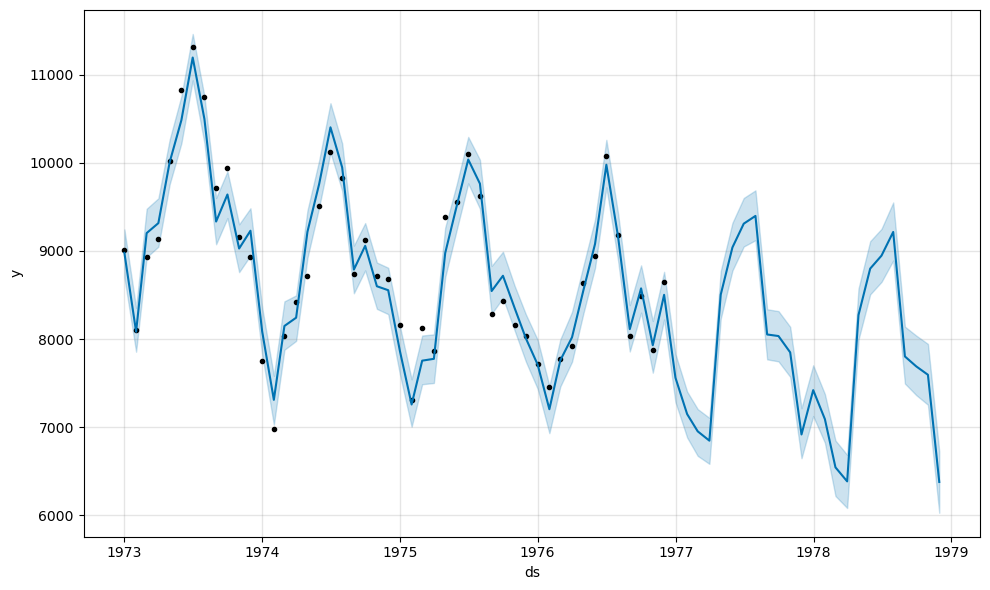

In [433]:
m.plot(forecast);

Смотрится неплохо

In [463]:
print(mean_squared_error(df['y'][-24:], forecast['yhat'][-24:].astype(int)))
print(mean_absolute_error(df['y'][-24:], forecast['yhat'][-24:].astype(int)))

1259079.875
904.625


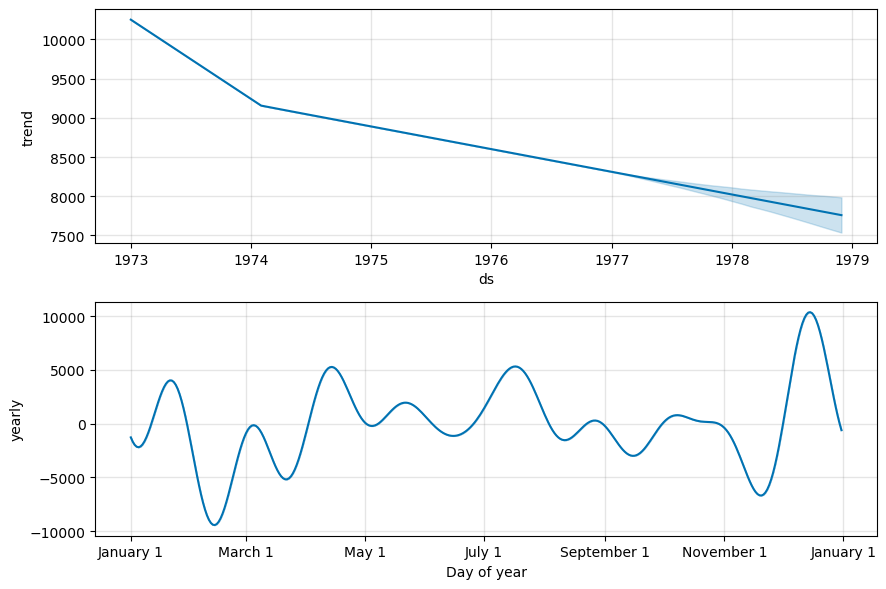

In [464]:
m.plot_components(forecast);

Переобучим модель на всем датасете

In [465]:
m = Prophet()
m.fit(df);

22:05:52 - cmdstanpy - INFO - Chain [1] start processing
22:05:52 - cmdstanpy - INFO - Chain [1] done processing


In [466]:
future = m.make_future_dataframe(periods=24, freq = 'M')
future.tail()

,ds
91,1980-07-31
92,1980-08-31
93,1980-09-30
94,1980-10-31
95,1980-11-30


In [467]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
91,1980-07-31,10586.453568,10246.845844,10895.076951
92,1980-08-31,9501.568553,9164.111740,9853.421879
93,1980-09-30,9505.919329,9171.058166,9873.194459
94,1980-10-31,9333.427065,8995.426877,9704.491373
95,1980-11-30,9030.339805,8692.031318,9408.771585


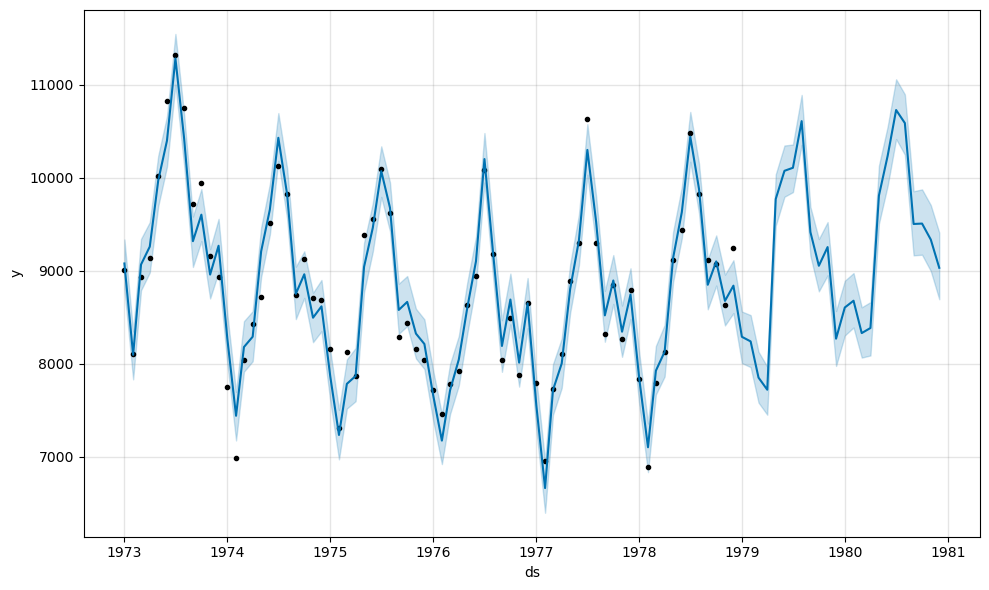

In [468]:
m.plot(forecast);

Смотрится довольно неплохо